**TODO** select non-overlapping windows only (to avoid the non-independence between sites)

The basic idea is to find out which categories of genomic regions (exons, promoters, enhancers, etc) contribute the most to the Nea. ancestry observed in present day Europeans. For example: have coding regions or enhancers been the main drivers of selection against Nea. introgression?

Links:

* info about different coordinate types: https://groups.google.com/forum/#!msg/biomart-users/OtQbAx3y9CA/wrF19ID1AgAJ
* https://www.biostars.org/p/2005/
* http://www.bioconductor.org/packages/release/bioc/vignettes/biomaRt/inst/doc/biomaRt.html#attribute-pages
* http://www.ensembl.org/info/data/biomart/biomart_r_package.html
* http://www.ensembl.info/blog/2015/06/01/biomart-or-how-to-access-the-ensembl-data-from-r/
* for checking with manually downloaded data: http://www.ensembl.org/info/data/biomart/how_to_use_biomart.html
* biotypes FAQ: http://www.ensembl.org/Help/Glossary

Following [this](http://www.ensembl.org/info/data/biomart/biomart_r_package.html) tutorial, I want to extract coordinates of exonic and regulatory regions from the Ensembl database and then calculate the density of such regions in a defined window around each SNP.

These densities will they be used as predictors in a linear model, predicting the Nea. ancestry at each site.

Alternatively, I could just test if the distribution of densities for different regions differ based on frequency of Nea. alleles at each site.

In [2]:
library(biomaRt)
library(rtracklayer)
library(BSgenome.Hsapiens.UCSC.hg19)

Loading required package: GenomicRanges
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit

Loading required package: S4Vectors
Loading required package: stats4

Attaching package: ‘S4Vectors’

The following object

In [3]:
library(tidyverse)
library(stringr)
library(magrittr)
library(parallel)
library(data.table)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
collapse(): dplyr, Biostrings, IRanges
combine():  dplyr, BiocGenerics
compact():  purrr, XVector
desc():     dplyr, IRanges
expand():   tidyr, S4Vectors
filter():   dplyr, stats
first():    dplyr, S4Vectors
lag():      dplyr, stats
Position(): ggplot2, BiocGenerics, base
reduce():   purrr, GenomicRanges, IRanges
rename():   dplyr, S4Vectors
select():   dplyr, biomaRt
simplify(): purrr, IRanges
slice():    dplyr, XVector, IRanges

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, last

The following object is masked from ‘package:purrr’:

 

## Get coordinates of admixture array sites

In [4]:
source("../R/utils.R")

In [5]:
european_ids <- get_european_ids("../raw_data/10_24_2014_SGDP_metainformation_update.txt")

europeans <-
    load_dataset("../clean_data/ice_age.tsv", "../clean_data/sgdp.tsv", "../clean_data/archaics.tsv",
                 random_sample=FALSE) %>%
    select(c("chrom", "pos", european_ids)) %>%
    mutate(chrom=paste0("chr", chrom))

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”Parsed with column specification:
cols(
  .default = col_character(),
  Latitude = col_double(),
  Longitude = col_double(),
  Coverage = col_integer(),
  HetRateAuto = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character(),
  Altai = col_integer(),
  Vindija = col_integer(),
  Denisovan = col_integer()
)
Joining, by = c

In [6]:
sites <-
    mutate(europeans, start=pos, end=pos) %>% 
    makeGRangesFromDataFrame
seqinfo(sites) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

In [7]:
length(sites)

[1] 484016

In [8]:
head(sites)

GRanges object with 6 ranges and 0 metadata columns:
      seqnames           ranges strand
         <Rle>        <IRanges>  <Rle>
  [1]     chr1 [847983, 847983]      *
  [2]     chr1 [853089, 853089]      *
  [3]     chr1 [853596, 853596]      *
  [4]     chr1 [854793, 854793]      *
  [5]     chr1 [867552, 867552]      *
  [6]     chr1 [871401, 871401]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

## Calculate the overlap of each window with each annotation feature

Those black magic GRanges overlap tricks are from [here](https://support.bioconductor.org/p/56880/).

In [9]:
WINDOW_SIZE <- 10

### Developing the code on a simple test example

Testing sites, testing windows (10 bp) and testing exons

In [9]:
# sites
(s <- GRanges(seqnames="chr1", ranges=IRanges(c(10, 16, 22, 100), width=1)))
seqinfo(s) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

# windows around sites
(w <- flank(s, as.integer(WINDOW_SIZE / 2), both=TRUE))
seqinfo(w) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

# regions of interest (like exons)
(r <- GRanges(seqnames="chr1", ranges=IRanges(start=c(7, 12, 16, 200), end=c(9, 13, 21, 220))))
seqinfo(r) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

GRanges object with 4 ranges and 0 metadata columns:
      seqnames     ranges strand
         <Rle>  <IRanges>  <Rle>
  [1]     chr1 [ 10,  10]      *
  [2]     chr1 [ 16,  16]      *
  [3]     chr1 [ 22,  22]      *
  [4]     chr1 [100, 100]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

GRanges object with 4 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1 [ 5,  14]      *
  [2]     chr1 [11,  20]      *
  [3]     chr1 [17,  26]      *
  [4]     chr1 [95, 104]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

GRanges object with 4 ranges and 0 metadata columns:
      seqnames     ranges strand
         <Rle>  <IRanges>  <Rle>
  [1]     chr1 [  7,   9]      *
  [2]     chr1 [ 12,  13]      *
  [3]     chr1 [ 16,  21]      *
  [4]     chr1 [200, 220]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

The densities in windows around the 4 testing sites are supposed to be 0.5, 0.7, 0.5 and 0.

Calculate the # of overlapping bases for each window:

In [10]:
# get the hit table between windows and regions they overlap with
(hits <- findOverlaps(w, r))

Hits object with 5 hits and 0 metadata columns:
      queryHits subjectHits
      <integer>   <integer>
  [1]         1           1
  [2]         1           2
  [3]         2           2
  [4]         2           3
  [5]         3           3
  -------
  queryLength: 4 / subjectLength: 4

In [11]:
# get all overlapping regions (duplicates for regions
# overlapping several windows/sites)
(w_over <- pintersect(w[queryHits(hits)], r[subjectHits(hits)]))

GRanges object with 5 ranges and 1 metadata column:
      seqnames    ranges strand |       hit
         <Rle> <IRanges>  <Rle> | <logical>
  [1]     chr1  [ 7,  9]      * |      TRUE
  [2]     chr1  [12, 13]      * |      TRUE
  [3]     chr1  [12, 13]      * |      TRUE
  [4]     chr1  [16, 20]      * |      TRUE
  [5]     chr1  [17, 21]      * |      TRUE
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

In [12]:
# for each window count the number of overlapping bases in regions
# as an integer vector
(w_counts <- tapply(w_over, queryHits(hits), FUN=function(x) sum(width(x))))

1 2 3 
5 7 5

In [13]:
# add the column with % overlap to the original sites object
s$overlap <- 0
s$overlap[as.numeric(names(w_counts))] <- unname(w_counts) / WINDOW_SIZE
s

GRanges object with 4 ranges and 1 metadata column:
      seqnames     ranges strand |   overlap
         <Rle>  <IRanges>  <Rle> | <numeric>
  [1]     chr1 [ 10,  10]      * |       0.5
  [2]     chr1 [ 16,  16]      * |       0.7
  [3]     chr1 [ 22,  22]      * |       0.5
  [4]     chr1 [100, 100]      * |         0
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

### The code seems to work, let's construct a function:

In [10]:
# construct windows around each site in a GRanges object
create_windows <- function(sites, window_size) {
    windows <- flank(sites, as.integer(window_size / 2), both=TRUE)
    seqinfo(windows) <- seqinfo(sites)
    
    windows
}

calc_window_overlaps <- function(sites, regions, window_size) {
    windows <- create_windows(sites, window_size)

    # get the hit table between windows and regions they overlap with
    hits <- findOverlaps(windows, regions)

    # get the all overlapping regions (duplicates for regions
    # overlapping several windows/sites)
    w_over <- pintersect(windows[queryHits(hits)], regions[subjectHits(hits)])

    # for each window count the number of overlapping bases in regions
    # as an integer vector
    w_counts <- tapply(w_over, queryHits(hits), FUN=function(x) { sum(width(x)) })

    # add the column with % overlap to the original sites object
    sites$overlap <- 0 # by default zero overlap for each site
    sites$overlap[as.numeric(names(w_counts))] <- unname(w_counts) / window_size

    sites$overlap
}

Test of this function on the toy dataset from above:

In [15]:
calc_window_overlaps(granges(s), r, WINDOW_SIZE)

[1] 0.5 0.7 0.5 0.0

It works!

# Fetching genome annotation data

In [16]:
WINDOW_SIZE <- 100000

In [17]:
regions <- list()

## Exon coordinates

Show all the available biomarts for hg19:

In [18]:
listMarts(host="grch37.ensembl.org")

biomart,version
ENSEMBL_MART_ENSEMBL,Ensembl Genes 89
ENSEMBL_MART_SNP,Ensembl Variation 89
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 89


Connect to the human gene Ensembl dataset:

In [19]:
ensembl_mart_genes <- useMart("ENSEMBL_MART_ENSEMBL", host="grch37.ensembl.org")
listDatasets(ensembl_mart_genes) %>% filter(str_detect(dataset, "sapiens"))

dataset,description,version
hsapiens_gene_ensembl,Human genes (GRCh37.p13),GRCh37.p13


In [20]:
genes <- useDataset(dataset="hsapiens_gene_ensembl", mart=ensembl_mart_genes)

Get coordinates of protein_coding regions and lincRNAs from the gene annotation database:

In [21]:
genes_df <-
    getBM((listAttributes(genes) %>% filter(page=="structure"))$name,    # get all attributes
          filters=c("chromosome_name", "biotype"),                       # filter for chromosome and biotype
          values=list(1:22, c("protein_coding", "lincRNA")),                           # chromosomes 1:22 and "protein_coding"
          mart=genes) %>%
    dplyr::select(chromosome_name, exon_chrom_start, exon_chrom_end, gene_biotype) %>%
    setNames(c("chrom", "start", "end", "feature")) %>%
    arrange(chrom, start) %>% 
    mutate(chrom=paste0("chr", chrom))

In [22]:
regions <- lapply(split(genes_df, genes_df$feature),
                  function(df) { IRanges::reduce(makeGRangesFromDataFrame(df)) })

How many exons did I get? What is the total length of the exonic sequence (in Mb) that we extracted?

Bioinformatic databases are a mess - are the numbers I get reasonable?

In [23]:
cat("number of exons: ", length(regions[["protein_coding"]]), "\n");
cat("total amount of exonic sequence:", sum(width(regions[["protein_coding"]])) / 1e6, "Mb");

number of exons:  222587 
total amount of exonic sequence: 89.81306 Mb

## Coordinates of regulatory features

It took forever to find out, how to get the regulatory features. In the end I found it totally by accident in some bugreport mail :( https://support.bioconductor.org/p/39545/

Show all the available biomarts for hg19:

In [24]:
listMarts(host="grch37.ensembl.org")

biomart,version
ENSEMBL_MART_ENSEMBL,Ensembl Genes 89
ENSEMBL_MART_SNP,Ensembl Variation 89
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 89


Connect to the human gene Ensembl dataset:

In [25]:
ensembl_mart_funcgen <- useMart("ENSEMBL_MART_FUNCGEN", host="grch37.ensembl.org")
listDatasets(ensembl_mart_funcgen) %>% filter(str_detect(dataset, "sapiens"))

dataset,description,version
hsapiens_regulatory_feature,Human Regulatory Features (GRCh37.p13),GRCh37.p13
hsapiens_external_feature,Human Other Regulatory Regions (GRCh37.p13),GRCh37.p13
hsapiens_motif_feature,Human Binding Motifs (GRCh37.p13),GRCh37.p13
hsapiens_mirna_target_feature,Human miRNA Target Regions (GRCh37.p13),GRCh37.p13
hsapiens_annotated_feature,Human Regulatory Evidence (GRCh37.p13),GRCh37.p13


In [26]:
regulation <- useDataset(dataset="hsapiens_regulatory_feature", mart=ensembl_mart_funcgen)

Download the dataframe from Biomart:

In [27]:
regulatory_features_df <-
    getBM(attributes=c("chromosome_name", "chromosome_start", "chromosome_end", "feature_type_name"),
          filters="chromosome_name",
          values=1:22,
          mart=regulation) %>%
    setNames(c("chrom", "start", "end", "feature")) %>%  # rename the columns to BED names
    mutate(feature=str_replace_all(tolower(feature), " ", "_")) %>% 
    filter(! feature %in% c("open_chromatin", "promoter_flanking_region")) %>% 
    arrange(chrom, start) %>%
    mutate(chrom=paste0("chr", chrom))

In [28]:
table(regulatory_features_df$feature)


ctcf_binding_site          enhancer          promoter   tf_binding_site 
            55194             27577             14287             22376 

## Coordinates of primate phastCons elements

How to retrieve them: https://support.bioconductor.org/p/25587/

Per-base vs elements diference: https://www.biostars.org/p/2129/#2143

In [29]:
library(rtracklayer)

In [30]:
session <- browserSession()
genome(session) <- "hg19"

Future note - there is "neandertalMethylation" in here - ha!

In [31]:
# trackNames(session) # show the available track names -- look for conservation track

In [32]:
query <- ucscTableQuery(session, "cons46way", GRangesForUCSCGenome("hg19", chrom=paste0("chr", 1:22)))

In [33]:
tableNames(query)

[1] "phyloP46wayPrimates"             "phyloP46wayPlacental"           
 [3] "phyloP46wayAll"                  "phastCons46wayPrimates"         
 [5] "phastCons46wayPlacental"         "phastCons46way"                 
 [7] "phastConsElements46wayPrimates"  "phastConsElements46wayPlacental"
 [9] "phastConsElements46way"          "multiz46way"

In [34]:
tableName(query) <- "phastConsElements46wayPrimates"

In [35]:
regions[["priPhastCons"]] <- track(query)

## Coordinates of primate phastCons elements that do not overlap anything else

Presumably some of the phastCons elements could be just exons, enhancers, etc... so let's keep only those conserved regions that are not exons, enhancers. etc.

A little test first:

In [36]:
(x <- GRanges(1,IRanges(c(1), c(1000))))
(y <- GRanges(1, IRanges(c(10, 500), c(50, 800))))
# subtract y from x
IRanges::setdiff(x,y)

GRanges object with 1 range and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]        1 [1, 1000]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

GRanges object with 2 ranges and 0 metadata columns:
      seqnames     ranges strand
         <Rle>  <IRanges>  <Rle>
  [1]        1 [ 10,  50]      *
  [2]        1 [500, 800]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

GRanges object with 3 ranges and 0 metadata columns:
      seqnames      ranges strand
         <Rle>   <IRanges>  <Rle>
  [1]        1 [  1,    9]      *
  [2]        1 [ 51,  499]      *
  [3]        1 [801, 1000]      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

Get the coordinates of exons, promoters, enhancers, etc.

In [37]:
other_regions <- unlist(GRangesList(regions[which(names(regions) != "priPhastCons")]))

In [38]:
regions[["priPhastCons_unique"]] <- IRanges::setdiff(regions[["priPhastCons"]], other_regions)

## Average per-base values of primate phastCons for each window

[description of the table](http://hgsv.washington.edu/cgi-bin/hgTables?db=hg19&hgta_group=compGeno&hgta_track=cons46way&hgta_table=phastCons46wayPrimates&hgta_doSchema=describe+table+schema)

https://www.biostars.org/p/2129/#2143

UCSC restrictions make it impossible for `rtracklayer` to download everything at once (limit of 1000 regions at once?) https://support.bioconductor.org/p/54143/

wig vs bigwig: https://support.bioconductor.org/p/55605/

Download the phastConst primate alignment conservation data, if they are not present yet:

Convert the phastConst wiggle files into bigwig files:

Calculate an average phastCons value per window and save it as a data column into the `sites` `GRanges` object (the warnings are caused by SNPs that are closer to the end of a chromosome than by a `WINDOW_SIZE` bp):

## Combine all regions into a single GRanges object

Split the regulatory features dataframes into a list of multiple dataframes, convert them to `GRanges` objects and merge with the exons `GRanges` object into a single list.

In [43]:
regions <- c(regions,
             lapply(split(regulatory_features_df, regulatory_features_df$feature),
                    makeGRangesFromDataFrame))

In [44]:
names(regions)

[1] "lincRNA"             "protein_coding"      "priPhastCons"       
[4] "priPhastCons_unique" "ctcf_binding_site"   "enhancer"           
[7] "promoter"            "tf_binding_site"

## Calculating the density of windows per SNP covered by different classes of regions

In [45]:
for (r in names(regions)) {
    overlaps_per_chr <- mclapply(paste0("chr", 1:22),
                                 function(chr) {
                                     calc_window_overlaps(sites[seqnames(sites) == chr],
                                                          regions[[r]],
                                                          WINDOW_SIZE)
                                 }, mc.cores=22)

    mcols(sites)[[r]] <- do.call(c, overlaps_per_chr)
}

## Average primate phastCons per window

In [175]:
priPhastCons_avg <-
    read.table("../clean_data/annotations/priPhCons__100000bp.bed", header=FALSE) %>%
    .[1:4] %>%
    setNames(c("chrom", "start", "end", "value")) %>%
    arrange(chrom, start) %>% 
    mutate(chrom=paste0("chr", chrom)) %>% 
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE, keep.extra=TRUE)

In [176]:
mcols(sites)[["priPhastCons_avg"]] <- subsetByOverlaps(priPhastCons_avg, sites)$value

Does average phastCons per 100kb window around a SNP correlate with the density of discrete phastCons elements in that window?

Quite a bit

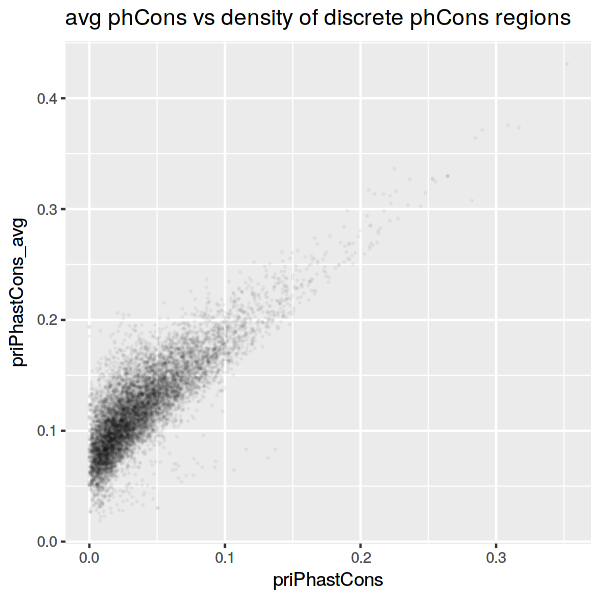

In [271]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=120)

ggplot(sample_n(as.data.frame(mcols(sites)), 10000), aes(priPhastCons, priPhastCons_avg)) +
    geom_point(size=0.1, alpha=1/30) +
    labs(title="avg phCons vs density of discrete phCons regions")

## Calculate Neanderthal allele frequency at each locus

In [178]:
mcols(sites)[["freq"]] <-
    select(europeans, -c(chrom, pos)) %>% # select only the genotype columns
    { apply(., 1, mean, na.rm=TRUE) / 2}  # calculate Nea. allele frequency

A couple of sanity checks - do we get an expected average Nea. allele frequency between 0 and 1 and mean of around 1.8% in Europeans?

In [179]:
summary(sites$freq)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00000 0.00000 0.00000 0.01890 0.01163 1.00000       4 

### Figure 1

Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”

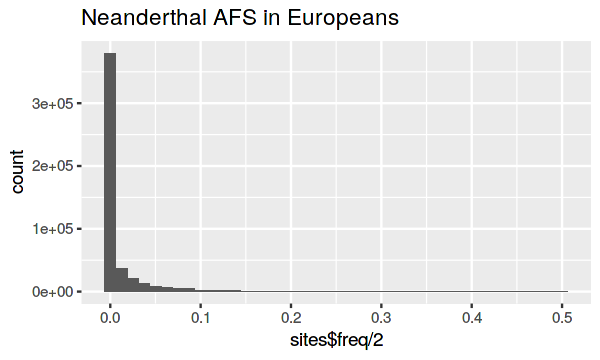

In [180]:
options(repr.plot.width=5, repr.plot.height=3, repr.plot.res=120)

qplot(sites$freq / 2, bins=ncol(europeans) - 4, main="Neanderthal AFS in Europeans")

Everything looks reasonable.

## Convert the final `GRanges` object to a normal data frame for the analyses bellow

In [181]:
tbl <- as.data.frame(sites) %>%
    select(-width, -strand) %>%
    rename(chrom=seqnames)

In [182]:
head(tbl)

chrom,start,end,lincRNA,protein_coding,priPhastCons,priPhastCons_unique,ctcf_binding_site,enhancer,promoter,tf_binding_site,priPhastCons_avg,freq
chr1,847983,847983,0.09540,0.09822,0.02802,0.01077,0.13582,0,0.04408,0.00836,0.047667,0
chr1,853089,853089,0.09540,0.12110,0.03514,0.01108,0.16800,0,0.05010,0.00836,0.049807,0
chr1,853596,853596,0.09395,0.12110,0.03514,0.01108,0.16800,0,0.05010,0.00836,0.049866,0
chr1,854793,854793,0.08935,0.12110,0.03514,0.01108,0.16208,0,0.05010,0.00836,0.049938,0
chr1,867552,867552,0.07569,0.17652,0.03811,0.01282,0.23551,0,0.05010,0.01122,0.047507,0
chr1,871401,871401,0.07569,0.17595,0.03853,0.01324,0.25000,0,0.05010,0.01532,0.045560,0


In [183]:
save(europeans, regions, sites, tbl,
     file="../RData/annotations.RData")

## Modeling the dependence of Nea. frequency on functional predictors

In [11]:
load("../RData/annotations.RData")

In [12]:
library(tidyverse)

Convert the table of overlaps at each site/window from wide into a long format:

In [13]:
tbl_long <-
    sample_n(tbl, 25000) %>% # take a subset of all ~500k sites (to make plotting easier)
    gather(region, overlap, -c(chrom, start, end, freq))

In [14]:
head(tbl_long)

chrom,start,end,freq,region,overlap
chr3,21088258,21088258,0.1046512,lincRNA,0.00000
chr6,164445149,164445149,0.0000000,lincRNA,0.00000
chr11,78576104,78576104,0.0000000,lincRNA,0.00000
chr3,99607379,99607379,0.0000000,lincRNA,0.00000
chr2,223983796,223983796,0.0000000,lincRNA,0.00000
chr2,138711141,138711141,0.0000000,lincRNA,0.00171


### Figure 2

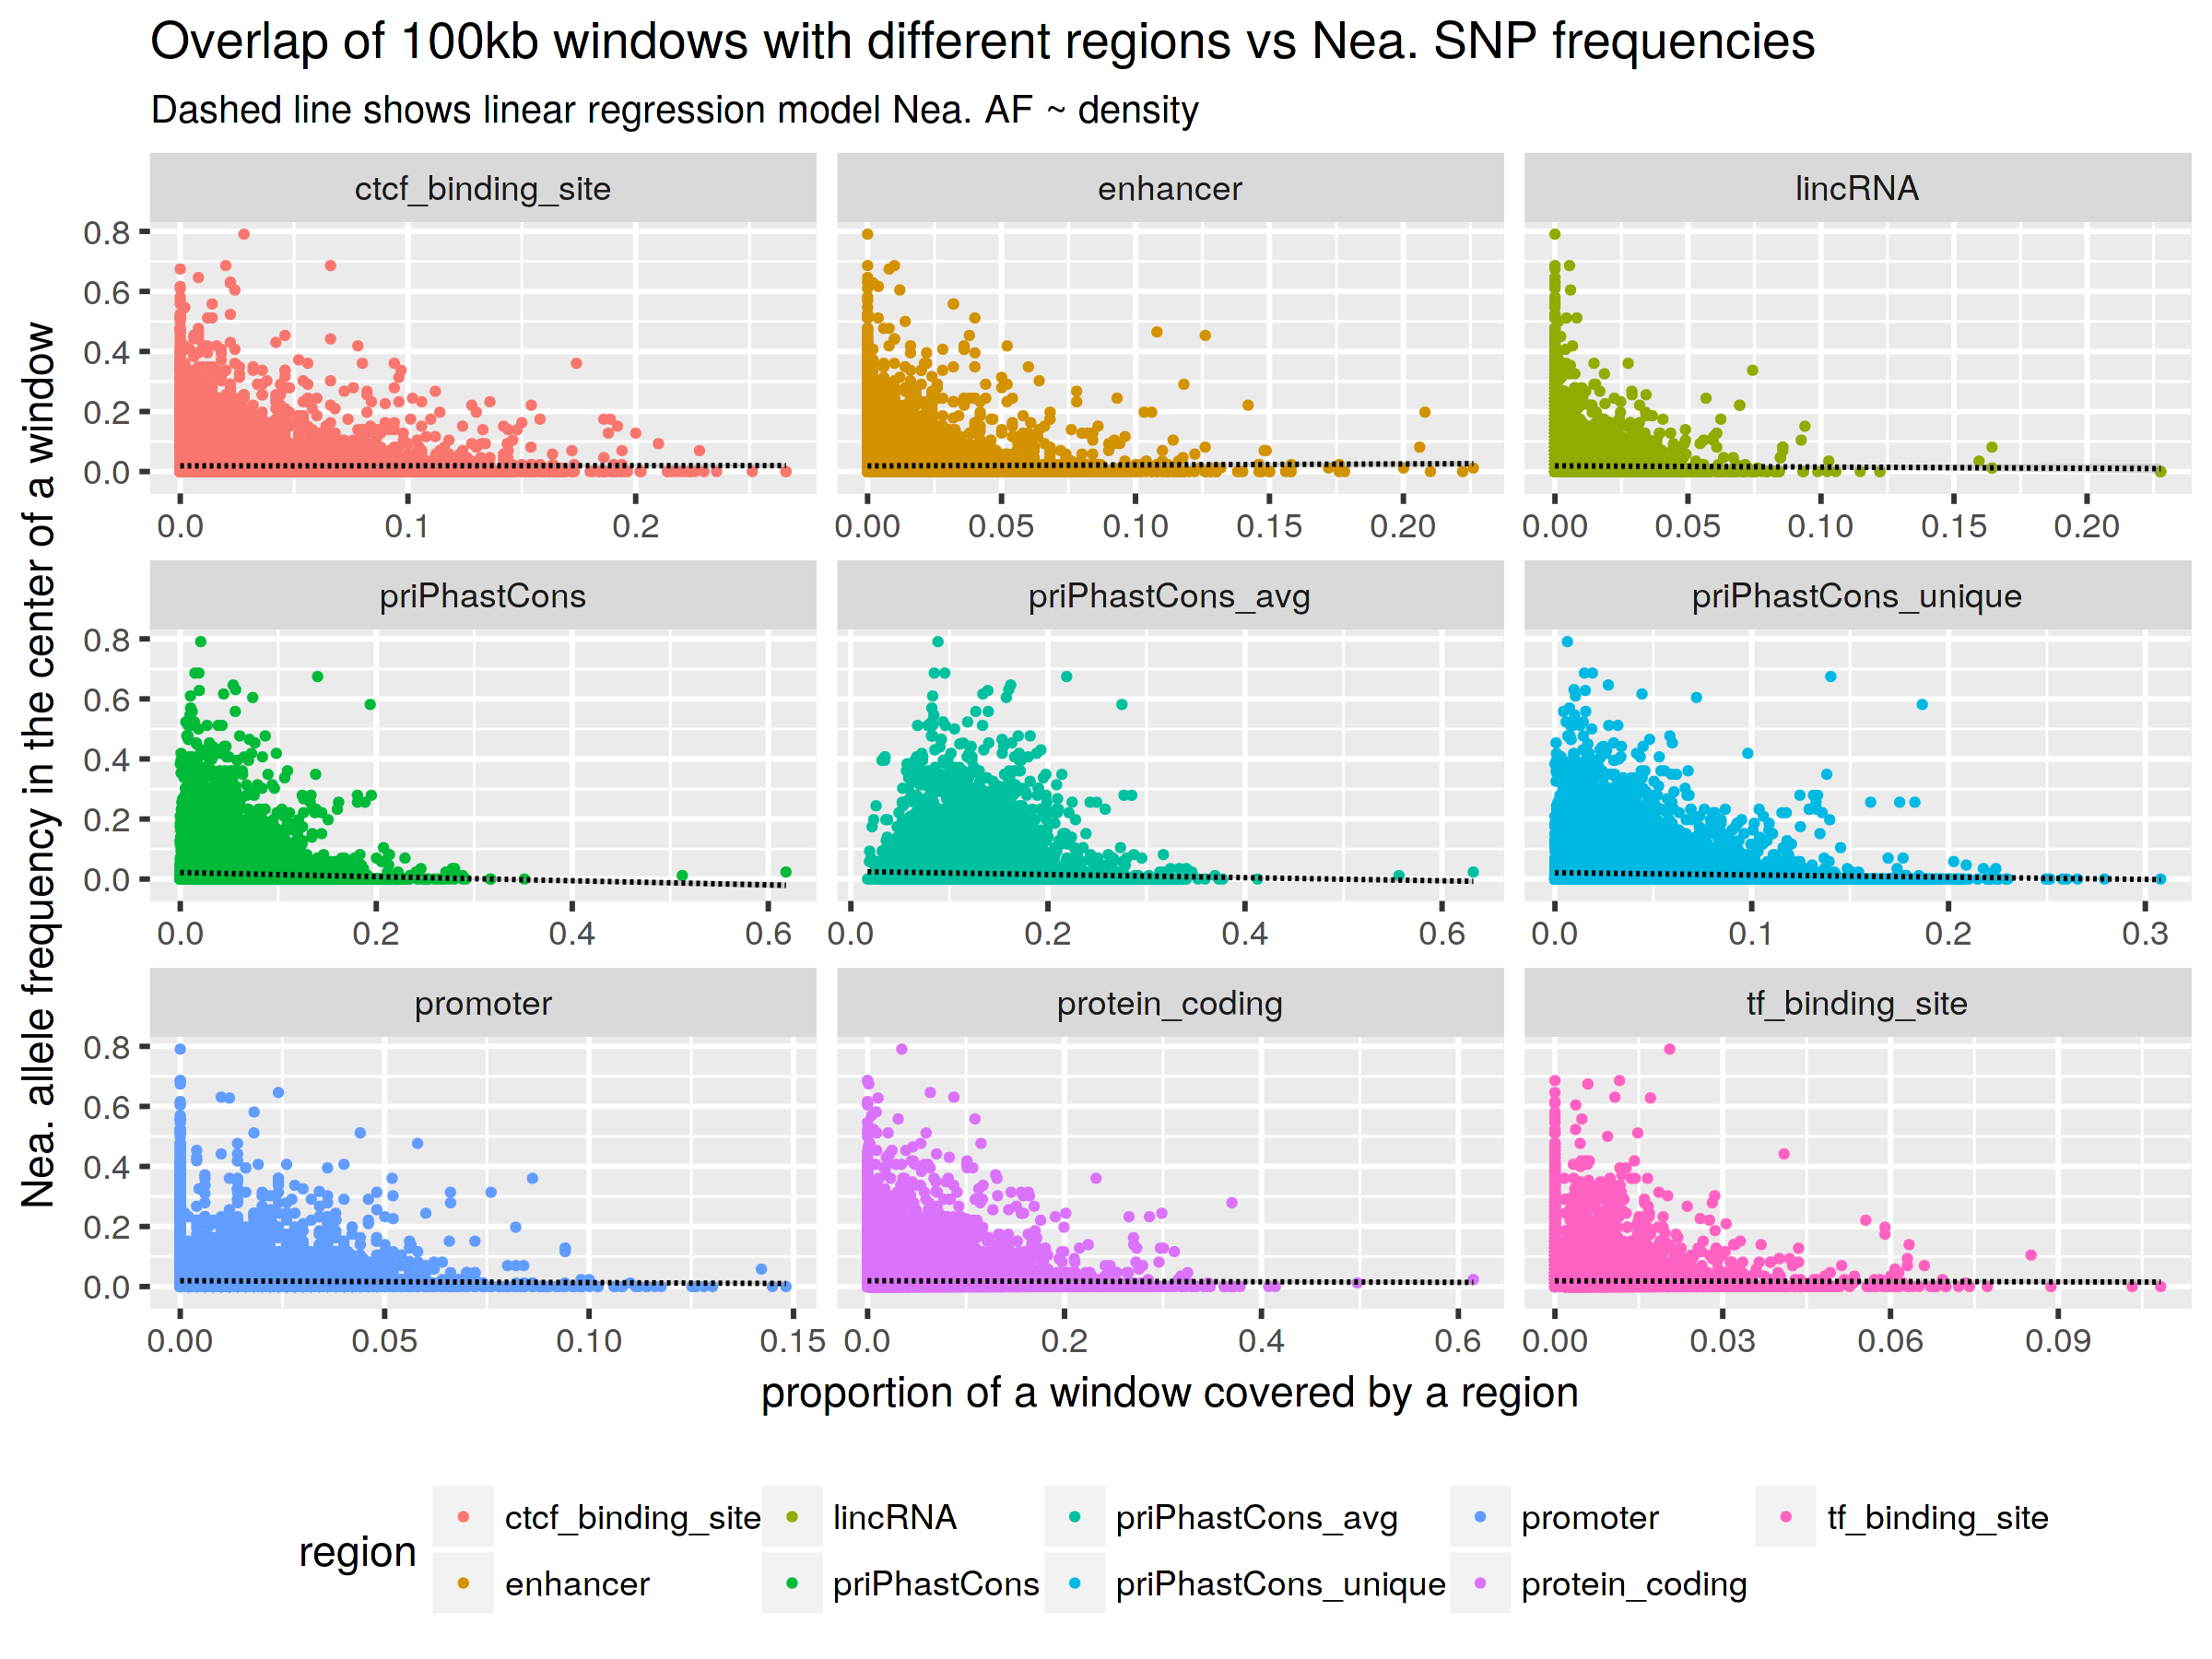

In [43]:
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res=300)

ggplot(tbl_long, aes(overlap, freq, color=region, group=region)) +
    geom_jitter(size=1/2) +
    geom_smooth(method="lm", color="black", linetype=2, size=0.5) +
    facet_wrap(~ region, scales="free_x") +
    theme(legend.position="bottom") +
    labs(x="proportion of a window covered by a region",
         y="Nea. allele frequency in the center of a window") +
    ggtitle(label="Overlap of 100kb windows with different regions vs Nea. SNP frequencies",
            subtitle="Dashed line shows linear regression model Nea. AF ~ density")


Call:
lm(formula = protein_coding ~ freq, data = tbl)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.03147 -0.03147 -0.02444  0.01431  0.62799 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.147e-02  7.557e-05 416.409   <2e-16 ***
freq        -1.273e-02  1.407e-03  -9.047   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04922 on 484010 degrees of freedom
  (4 observations deleted due to missingness)
Multiple R-squared:  0.0001691,	Adjusted R-squared:  0.000167 
F-statistic: 81.86 on 1 and 484010 DF,  p-value: < 2.2e-16


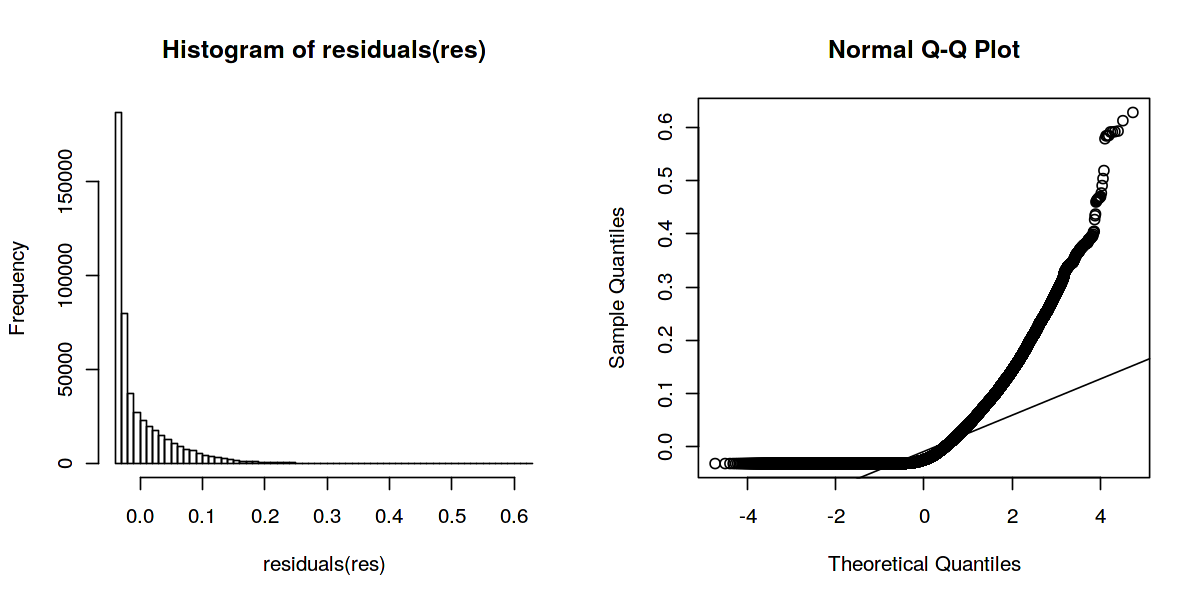

In [190]:
res <- lm(protein_coding ~ freq, data=tbl); summary(res)

options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=120)

par(mfcol=c(1, 2))
hist(residuals(res), breaks=50)
qqnorm(residuals(res)); qqline(residuals(res))

## Assign sites to extremes of each distribution

Based on a density of different functional elements in a window, assign each SNP to either "low density" or "high density" bin.

In [71]:
# Assign each site to either of the two extremes of each distribution.
# Sites that fall in the center of the distribution will be NA.
distr_extremes <- function(sites, track, lower_q=0.05, upper_q=0.95) {
    vals <- sites[[track]]

    qs <- quantile(vals, probs=c(lower_q, upper_q))

    bins <- ifelse(vals <= qs[1], "low",
            ifelse(vals > qs[2], "high", NA))
    
    bins
}


for (r in names(regions)) {
    tbl[[paste(r, "density", sep="_")]] <- distr_extremes(tbl, r) #, lower_q=0.025, upper_q=0.975)
}

In [72]:
bins_long <- tbl %>%
    select(chrom, start, end, contains("density")) %>%
    rename(pos=start) %>%
    mutate(chrom=as.character(chrom)) %>%
    select(-end) %>%
    gather(region, density, -c(chrom, pos)) %>%
    mutate(region=str_replace(region, "_density", "")) %>% 
    inner_join(europeans, by=c("chrom", "pos"))

In [73]:
head(bins_long)

chrom,pos,region,density,Abkhasian_2,Adygei_1,Adygei_2,Albanian_1,Basque_1,Basque_2,⋯,Orcadian_2,Polish_1,Russian_1,Russian_2,Sardinian_1,Sardinian_2,Spanish_1,Spanish_2,Tuscan_1,Tuscan_2
chr1,847983,lincRNA,high,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,853089,lincRNA,high,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,853596,lincRNA,high,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,854793,lincRNA,high,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,867552,lincRNA,high,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1,871401,lincRNA,high,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Calculate Nea. ancestry in low/high-density regions in each European:

In [74]:
nea_highlow <-
    bins_long %>%
    group_by(region, density) %>%
    filter(!is.na(density)) %>%
    summarise_at(european_ids, function(i) { mean(i, na.rm=TRUE) / 2 })

Calculate the genome-wide Nea. ancestry in each European:

In [75]:
nea_genomewide <- bins_long %>%
    summarise_at(european_ids, function(i) { mean(i, na.rm=TRUE) / 2 }) %>%
    mutate(region="genome_wide", density="-")

Plot the distributions of Nea. ancestry proportions (in all Europeans) in windows with low vs high density of different functional elements - is there any evidence that some of those regions might have been driving negative selection against introgression?

### Figure 3

In [76]:
nea_est <- bind_rows(nea_highlow, nea_genomewide) %>%
    gather(sample, nea_anc, -region, -density) %>%
    ungroup %>% 
    mutate(region=factor(region, levels=c("genome_wide", "priPhastCons", "priPhastCons_unique", "protein_coding",
                                          "promoter", "enhancer", "ctcf_binding_site", "tf_binding_site",
                                          "lincRNA")))

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

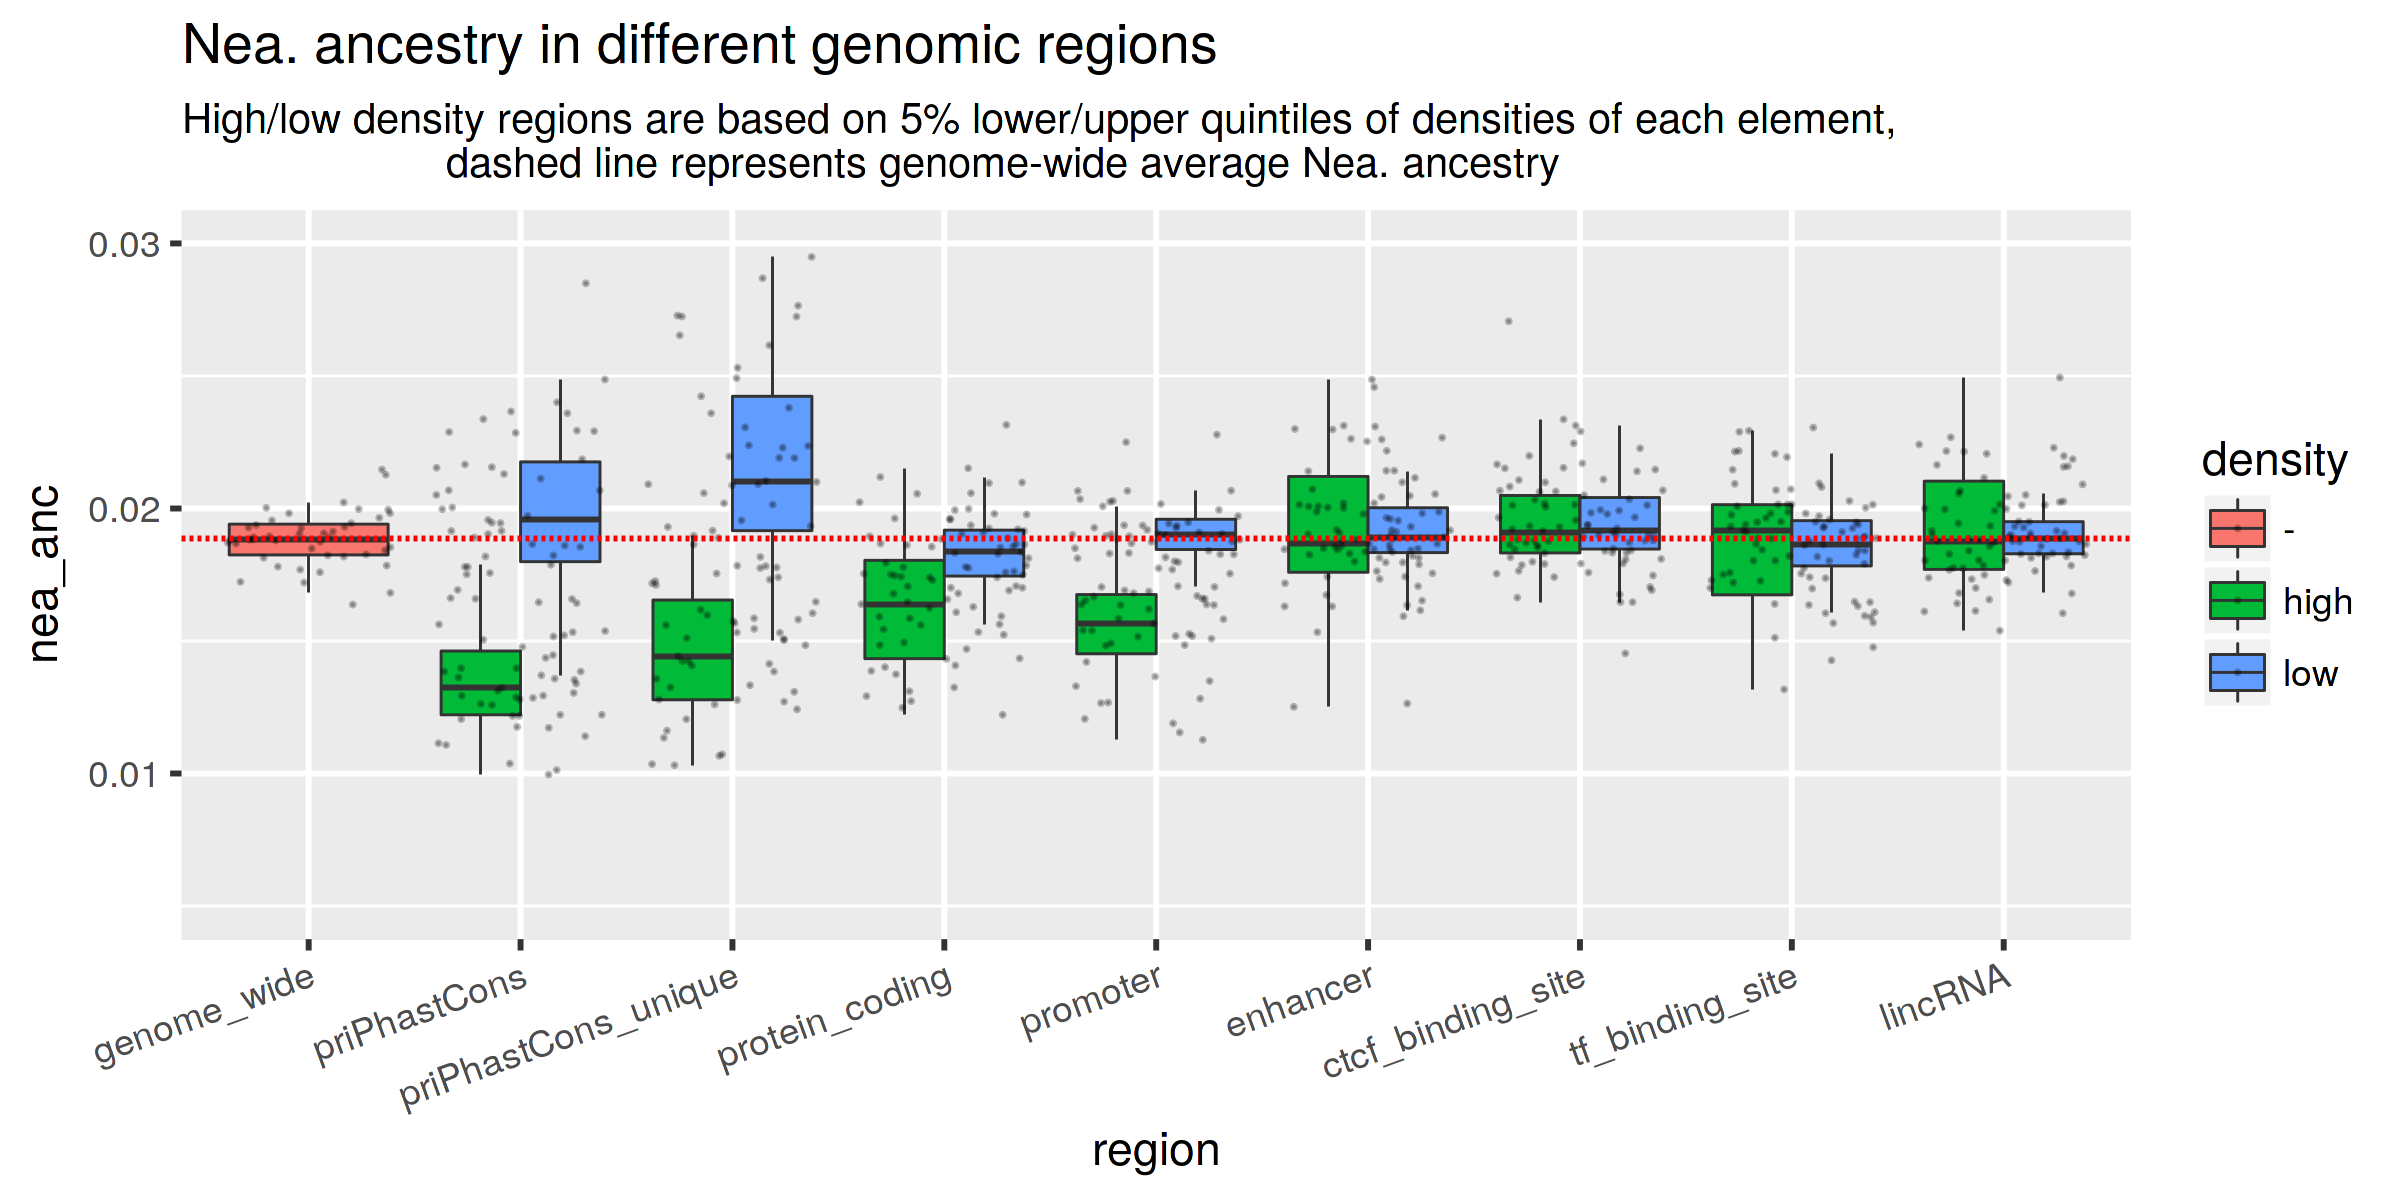

In [231]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res=300)

ggplot(nea_est, aes(region, nea_anc, fill=density)) +
    geom_boxplot(size=0.25, outlier.size=NA) +
    geom_jitter(size=0.01, alpha=0.25) +
    geom_hline(yintercept=mean(filter(nea_est, region == "genome_wide")$nea_anc), color="red", linetype=2) +
    ylim(0.005, 0.03) +
    theme(axis.text.x=element_text(angle=20, hjust=1)) +
    ggtitle("Nea. ancestry in different genomic regions",
            subtitle="High/low density regions are based on 5% lower/upper quintiles of densities of each element,
                      dashed line represents genome-wide average Nea. ancestry")

In the plot above, `priPhastCons` is based on a density of conserved elements (not the average phastCons in a window as before!) observed using primate alignment. `priPhastCons_unique` is a density of such elements _excluding_ those that overlap known exons, promoters, enhancers, etc.

Interestingly, density of conserved elements seems to have an even higher effect than density of exons or promoters. This is even more striking if we exclude sequence from the conserved regions track which overlaps exons, promoters and other regions.

However, enhancers etc don't have any effect at all - what are then the super-conserved and super-neutral genomic regions driving the negative selection signal?

In [202]:
x <- as.data.frame(sites) %>%
    select(-c(width, strand, freq, priPhastCons, priPhastCons_unique)) %>%
    rename(chrom=seqnames)

In [203]:
head(x, 1)

chrom,start,end,lincRNA,protein_coding,ctcf_binding_site,enhancer,promoter,tf_binding_site,priPhastCons_avg
chr1,847983,847983,0.0954,0.09822,0.13582,0,0.04408,0.00836,0.047667


In [204]:
n_bins <- 10

cutoffs <- quantile(x[["priPhastCons_avg"]], prob=seq(0, 1, length.out=n_bins + 1), na.rm=TRUE)

x %<>% mutate(priPhastCons_avg=factor(findInterval(priPhastCons_avg,
                                            vec=cutoffs,
                                            rightmost.closed=TRUE)))

In [205]:
head(x, 1)

chrom,start,end,lincRNA,protein_coding,ctcf_binding_site,enhancer,promoter,tf_binding_site,priPhastCons_avg
chr1,847983,847983,0.0954,0.09822,0.13582,0,0.04408,0.00836,1


In [206]:
cons_bins <- split(x, x$priPhastCons_avg)

In [207]:
y <- lapply(cons_bins, function(df) {
    densities <- select(df, -c(chrom, start, end, priPhastCons_avg))
    for (r in names(densities)) {
        df[[r]] <- distr_extremes(df, r)
    }
    df
})

In [208]:
z <- bind_rows(y) %>%
    gather(region, density, -c(chrom, start, end, priPhastCons_avg))

In [209]:
head(z, 1)

chrom,start,end,priPhastCons_avg,region,density
chr1,847983,847983,1,lincRNA,high


In [210]:
nea_cons_bins <- mutate(z, pos=end) %>%
    inner_join(europeans, by=c("chrom", "pos")) %>%
    group_by(priPhastCons_avg, region, density) %>%
    filter(!is.na(density)) %>%
    summarise_at(european_ids, function(i) { mean(i, na.rm=TRUE) / 2 })

Warning message:
“Column `chrom` joining factor and character vector, coercing into character vector”

In [211]:
head(nea_cons_bins, 1)

priPhastCons_avg,region,density,Abkhasian_2,Adygei_1,Adygei_2,Albanian_1,Basque_1,Basque_2,Bergamo_2,⋯,Orcadian_2,Polish_1,Russian_1,Russian_2,Sardinian_1,Sardinian_2,Spanish_1,Spanish_2,Tuscan_1,Tuscan_2
1,ctcf_binding_site,high,0.01360691,0.03864421,0.0187905,0.02310017,0.02698618,0.01446459,0.02590674,⋯,0.02720207,0.01813472,0.02530277,0.01622674,0.02094128,0.02420052,0.01903938,0.02158895,0.02439551,0.01532815


In [212]:
nea_cons_bins_long <- gather(nea_cons_bins, sample, nea_anc, -region, -density, -priPhastCons_avg) %>%
    ungroup %>% 
    mutate(region=factor(region, levels=c("genome_wide", "protein_coding", "promoter", "enhancer",
                                          "ctcf_binding_site", "tf_binding_site", "lincRNA")))

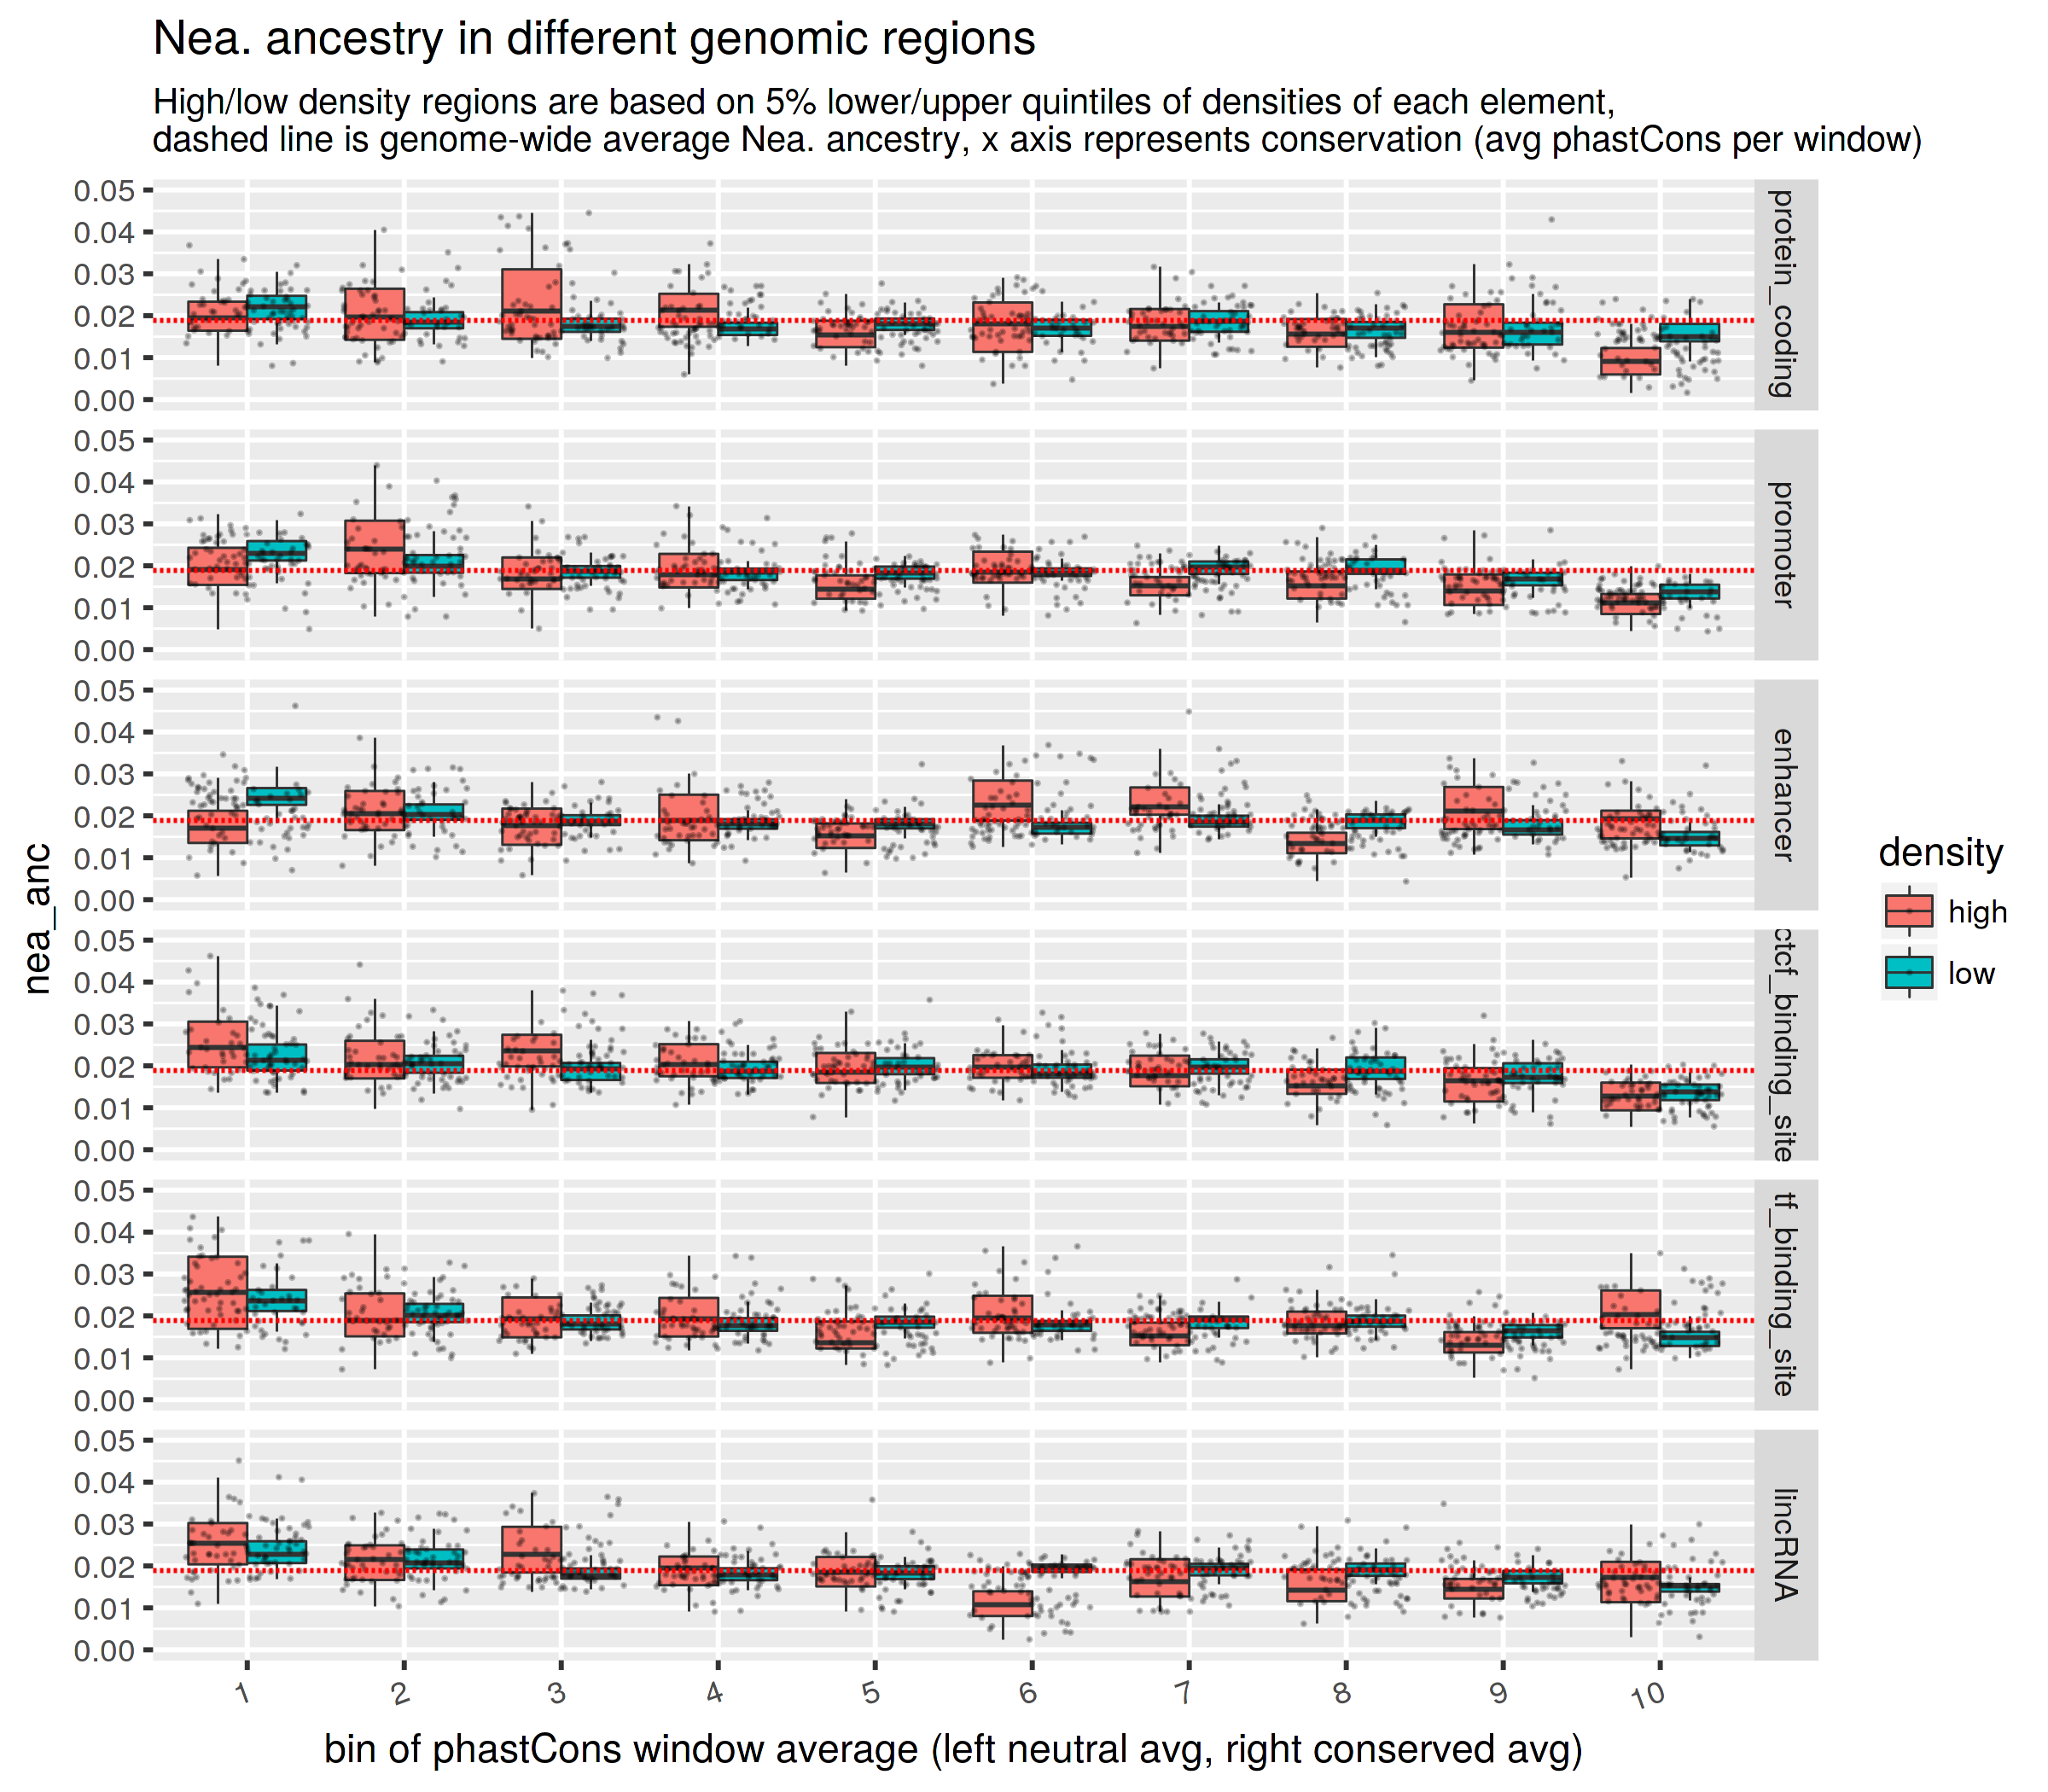

In [246]:
options(repr.plot.width=8, repr.plot.height=7, repr.plot.res=300)

ggplot(nea_cons_bins_long, aes(priPhastCons_avg, nea_anc, fill=density)) +
    geom_boxplot(size=0.25, outlier.size=NA) +
    geom_jitter(size=0.01, alpha=0.25) +
    geom_hline(yintercept=mean(t(select(nea_genomewide, one_of(european_ids)))), linetype=2, color="red") + 
    coord_cartesian(y=c(0.0, 0.05)) +
    facet_grid(region ~ .) +
    theme(axis.text.x=element_text(angle=20, hjust=1)) +
    xlab("bin of phastCons window average (left neutral avg, right conserved avg)") +
    ggtitle("Nea. ancestry in different genomic regions",
            subtitle="High/low density regions are based on 5% lower/upper quintiles of densities of each element,
dashed line is genome-wide average Nea. ancestry, x axis represents conservation (avg phastCons per window)")

## Phast const bins vs Nea%

In [237]:
n_bins <- 100

In [238]:
df <- as.data.frame(sites) %>%
    select(seqnames, start, end, priPhastCons_avg) %>%
    rename(chrom=seqnames, pos=start) %>%
    mutate(chrom=as.character(chrom)) %>%
    select(-end) %>%
    inner_join(europeans, by=c("chrom", "pos"))

In [239]:
cutoffs <- quantile(df[["priPhastCons_avg"]],
                    prob=seq(0, 1, length.out=n_bins + 1),
                    na.rm=TRUE)

df %<>% mutate(bin=findInterval(df[["priPhastCons_avg"]],
                                vec=cutoffs,
                                rightmost.closed=TRUE))

In [240]:
nea_bins <- group_by(df, bin) %>%
    summarise_at(european_ids, function(i) { mean(i, na.rm=TRUE) / 2 })

Warning message:
“Removed 3 rows containing missing values (geom_path).”

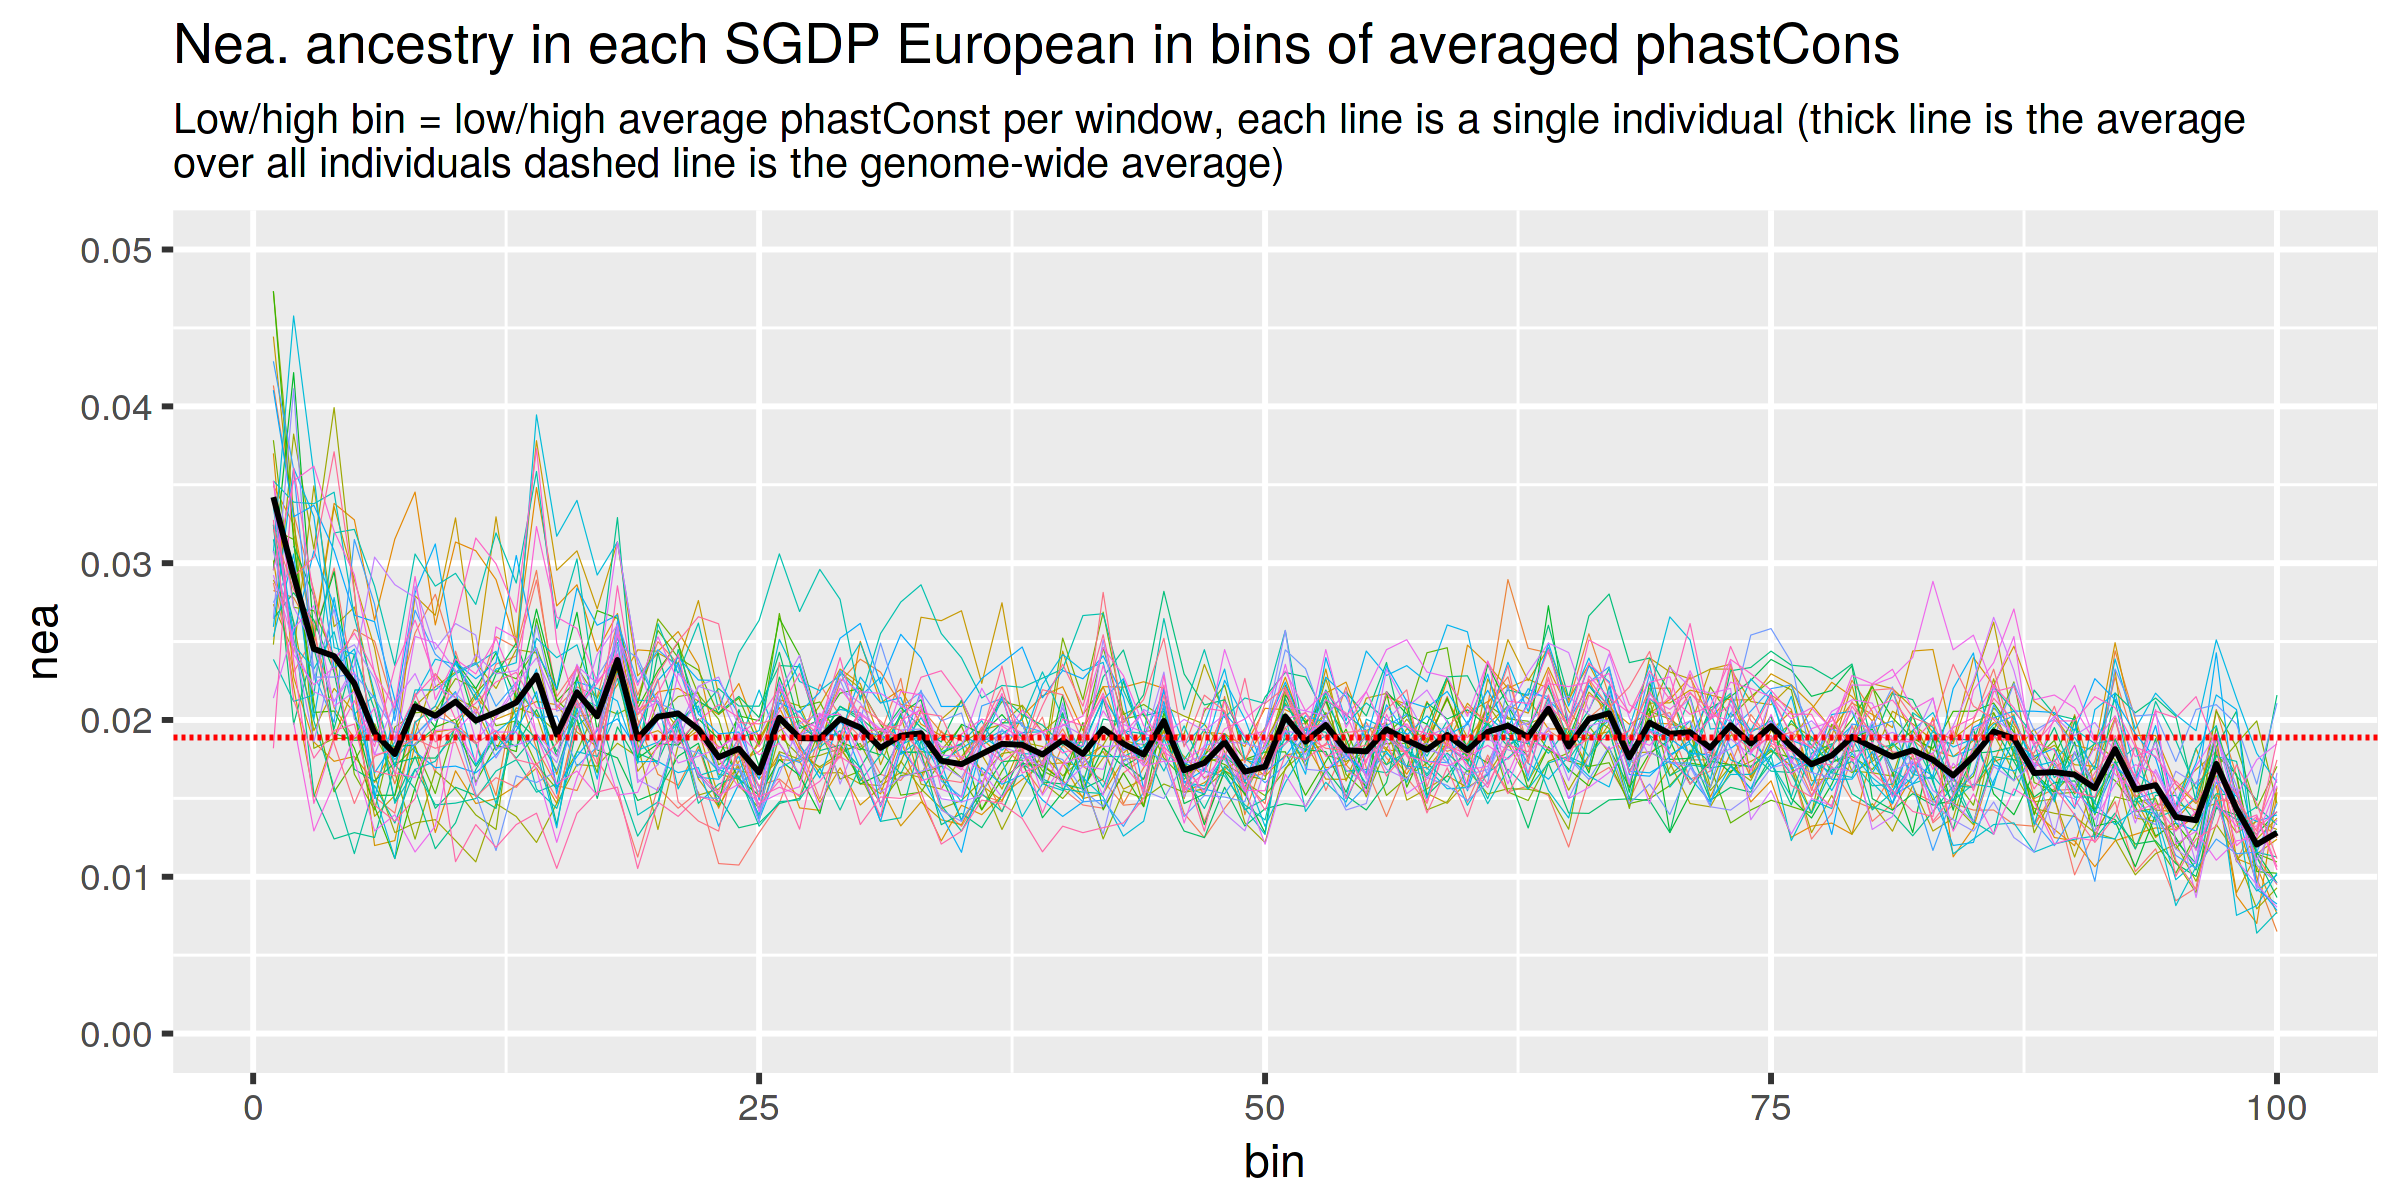

In [251]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res=300)

gather(nea_bins, name, nea, -bin) %>% 
    ggplot(aes(bin, nea, color=name)) +
    geom_line(size=0.1) +
    geom_line(data=(gather(nea_bins, name, nea, -bin) %>%
                    group_by(bin) %>%
                    summarise(f=mean(nea))),
              aes(bin, f),
              color="black") +
    geom_hline(yintercept=mean(t(select(nea_genomewide, one_of(european_ids)))), linetype=2, color="red") + 
    ylim(0, 0.05) + theme(legend.position="none") +
    ggtitle(label="Nea. ancestry in each SGDP European in bins of averaged phastCons",
            subtitle="Low/high bin = low/high average phastConst per window, each line is a single individual (thick line is the average
over all individuals dashed line is the genome-wide average)")

In [264]:
?pairs

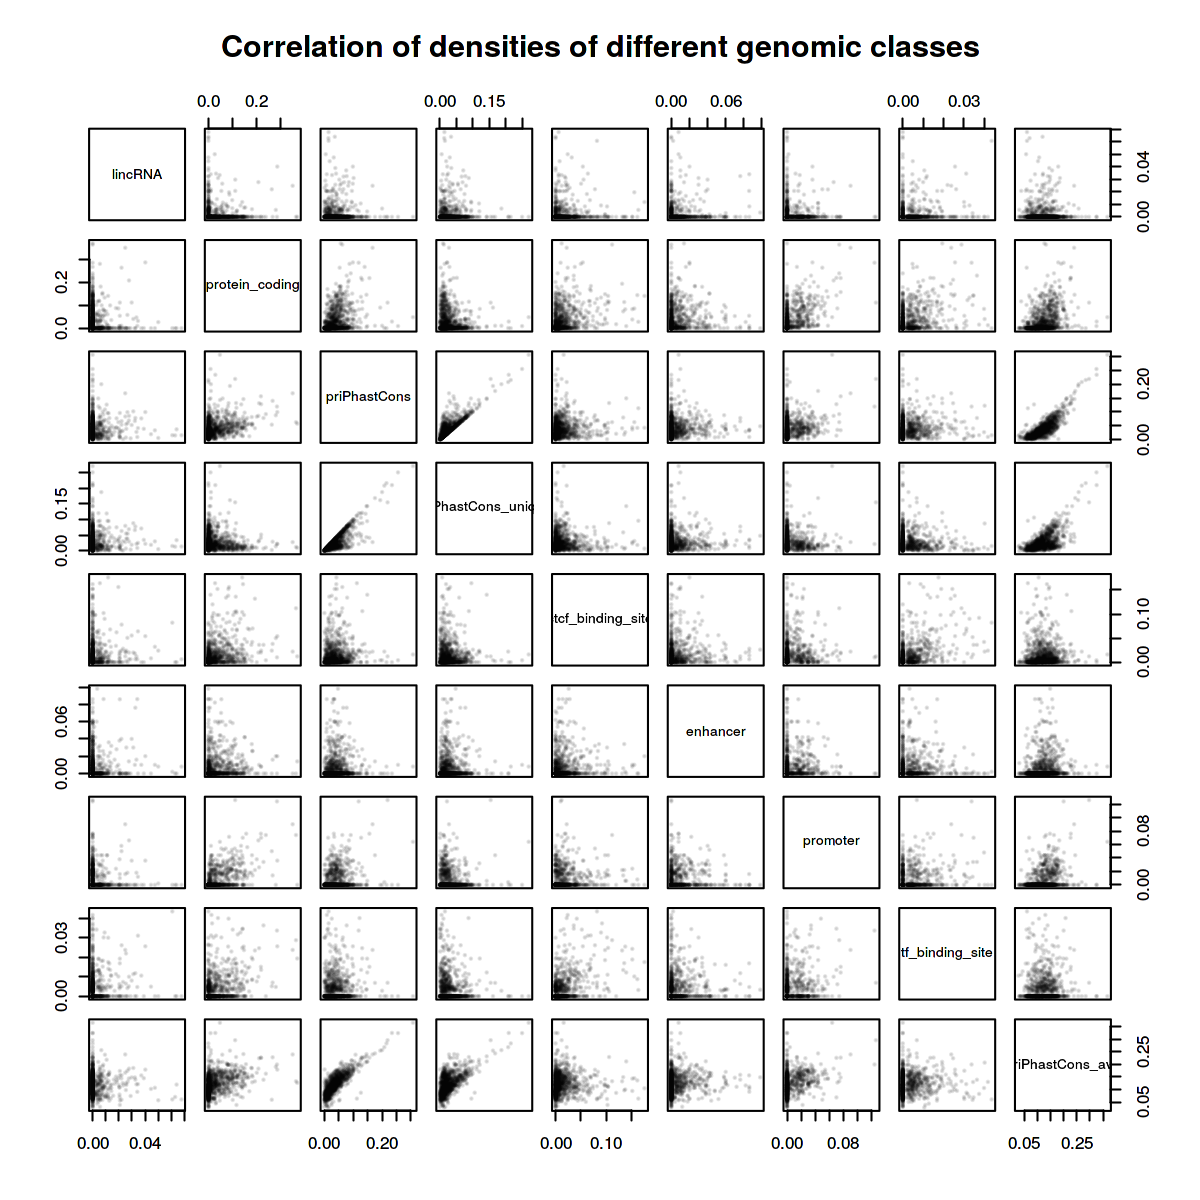

In [267]:
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res=150)

pairs(sample_n(tbl[4:12], 1000), main="Correlation of densities of different genomic classes",
      pch=19, cex=0.2, col=rgb(0, 0, 0, 0.1))

How does the new exon density metric compare to the old one?

Although both used the same data source (Ensembl - GTF from the FTP vs direct access to a database), there are some inconsistencies between the amount of exonic regions obtained from them... bioinformatics :(

In [131]:
# old exon densities
x <- read_tsv("../clean_data/annotations/exon_density__100000bp.bed",
              col_names=c("chrom", "start", "end", "overlap")) %>% mutate(chrom=paste0("chr", chrom))
e <- mutate(europeans, start=pos-1, end=pos) %>% dplyr::select(chrom, start, end)

old_exon_densities_from_gtf <- inner_join(x, e)

Parsed with column specification:
cols(
  chrom = col_integer(),
  start = col_integer(),
  end = col_integer(),
  overlap = col_double()
)
Joining, by = c("chrom", "start", "end")



	Pearson's product-moment correlation

data:  old_exon_densities_from_gtf$overlap and sites$exon
t = 2763.2, df = 484010, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9695676 0.9699034
sample estimates:
     cor 
0.969736 


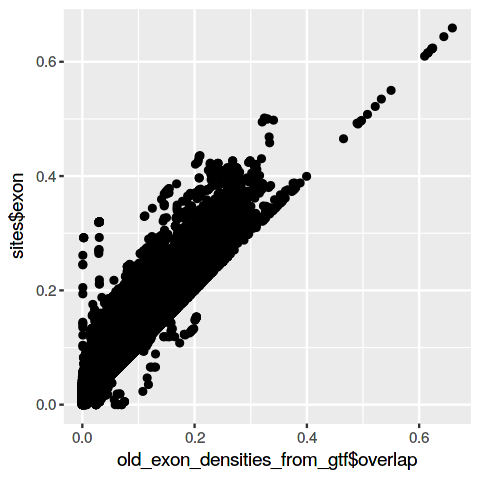

In [134]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res=120)
qplot(x=old_exon_densities_from_gtf$overlap, sites$exon)

cor.test(old_exon_densities_from_gtf$overlap, sites$exon)

It seems that there is more exonic sequence fetched via biomart than found in the GTF file from Ensembl's FTP. However, both measures of exonic density per SNP are very much correlated with each other, so everything should be fine.